# Resources
This notebook was possible due to 
- https://github.com/deepfindr/gnn-project
- https://www.youtube.com/watch?v=QLIkOtKS4os

# Installation

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install loguru

     |████████████████████████████████| 7.9 MB 32.5 MB/s 
     |████████████████████████████████| 3.5 MB 26.6 MB/s 
     |████████████████████████████████| 145 kB 15.8 MB/s 
     |████████████████████████████████| 74 kB 1.6 MB/s 
     |████████████████████████████████| 112 kB 43.8 MB/s 
     |████████████████████████████████| 596 kB 41.5 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 


## RDKit installation

In [2]:
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from loguru import logger
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


# Imports

In [22]:
import torch
import networkx as nx
import rdkit

In [76]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from loguru import logger

## Setting up device

In [5]:
available_device= "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(available_device)

# Working on Custom Dataset

Data can be found in
- https://github.com/deepfindr/gnn-project 

In [6]:
!git clone https://github.com/deepfindr/gnn-project 
!mkdir data
!mkdir data/raw
!cp gnn-project/data/raw/* ./data/raw/

Cloning into 'gnn-project'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 71 (delta 35), reused 56 (delta 20), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [7]:
hiv_df = pd.read_csv("data/raw/HIV_train.csv")
hiv_df.head()

,index,smiles,activity,HIV_active
0,3999,CC1c2nc(N)nc(N)c2CN1C(=O)c1ccccc1,CI,0
1,4000,Cc1nc(N)c2c(n1)C(C)N(C(=O)c1ccccc1)C2,CI,0
2,4001,NC(=S)NN=Cc1ccc(O)cn1,CI,0
3,4002,COC1C(OC(=O)c2ccc(C)[nH]2)C(O)C(Oc2ccc3c(O)c(N...,CM,1
4,4003,O=C1C=C2C=CC3CC2(O1)C1CCCCN31,CI,0


## Molecule Visualization

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [31]:
smiles = hiv_df[:9]["smiles"].values
len(smiles)

9

9


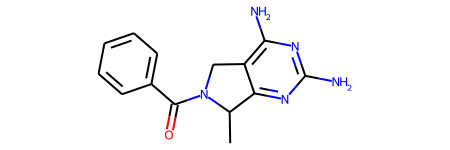

In [32]:
smile_mol = [Chem.MolFromSmiles(smile) for smile in smiles]
print(len(smile_mol))
smile_mol[0] 

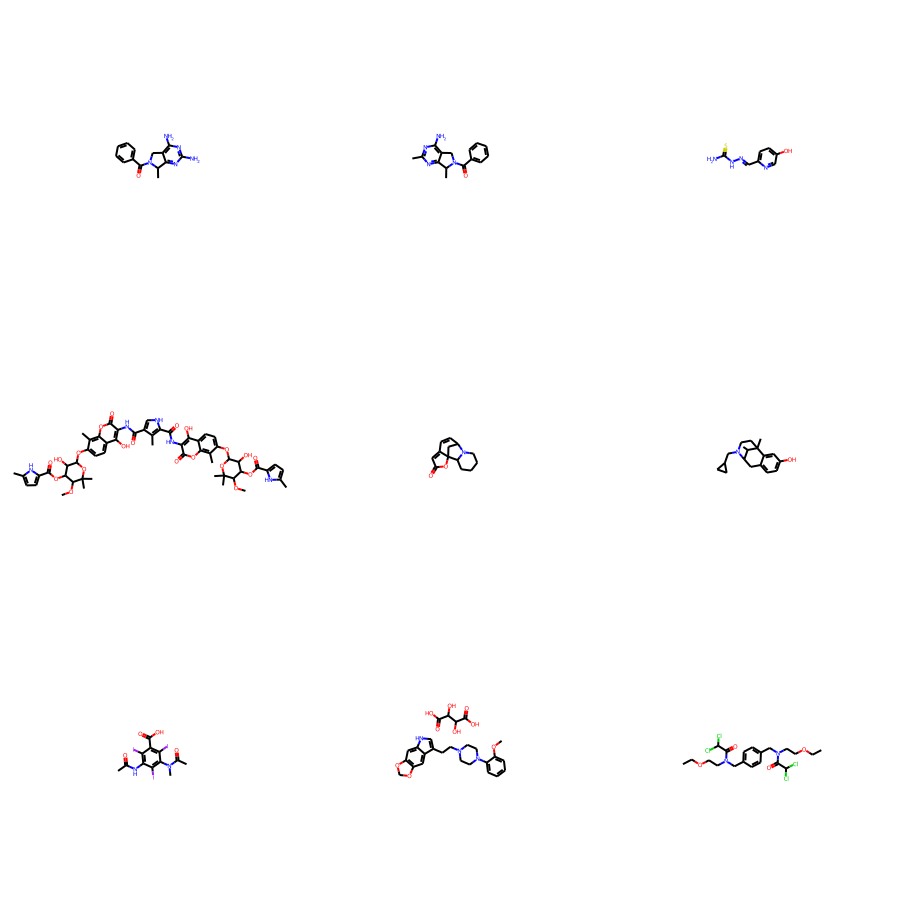

In [33]:
grid = Draw.MolsToGridImage(smile_mol,
                            molsPerRow=3,
                            subImgSize=(300,300))    
grid

## Let's explore a single molecule

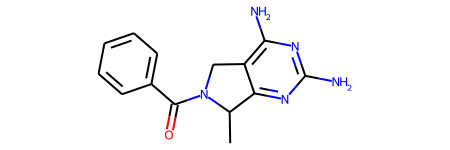

In [13]:
molecule = smile_mol[0]
molecule

In [14]:
len(molecule.GetAtoms()) # no. of nodes

20

### Node features

In [15]:
node_features = []
nodes = []
for atom in molecule.GetAtoms():
    node_feats = []
    # Feature 1: Atomic number        
    node_feats.append(atom.GetAtomicNum())
    # Feature 2: Atom degree
    node_feats.append(atom.GetDegree())
    # Feature 3: Formal charge
    node_feats.append(atom.GetFormalCharge())
    # Feature 4: Hybridization
    node_feats.append(atom.GetHybridization())
    # Feature 5: Aromaticity
    node_feats.append(atom.GetIsAromatic())
    # Feature 6: Total Num Hs
    node_feats.append(atom.GetTotalNumHs())
    # Feature 7: Radical Electrons
    node_feats.append(atom.GetNumRadicalElectrons())
    # Feature 8: In Ring
    node_feats.append(atom.IsInRing())
    # Feature 9: Chirality
    node_feats.append(atom.GetChiralTag())
    node_features.append(node_feats)

    nodes.append(atom.GetIdx()) 

node_features = np.asarray(node_features, dtype=np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [16]:
node_features.shape

(20, 9)

### Edges and its features 

In [17]:
len(molecule.GetBonds())

22

In [18]:
edge_features = []
edges_in_coo = []
for bond in molecule.GetBonds():
    edge_feats = []
    # Feature 1: Bond type (as double)
    edge_feats.append(bond.GetBondTypeAsDouble())
    # Feature 2: Rings
    edge_feats.append(bond.IsInRing())

    i_atom_idx = bond.GetBeginAtomIdx() # n_i
    j_atom_idx = bond.GetEndAtomIdx() # n_j

    edge_features += [edge_feats, edge_feats]

    edges_in_coo += [
                     [i_atom_idx, j_atom_idx], 
                     [j_atom_idx, i_atom_idx]
                     ]

In [19]:
edge_features = np.asarray(edge_features, dtype=np.float)
edge_features.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(44, 2)

In [46]:
edges_in_coo = np.asarray(edges_in_coo, dtype=np.long).T.reshape(2, -1)
edges_in_coo.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(2, 44)

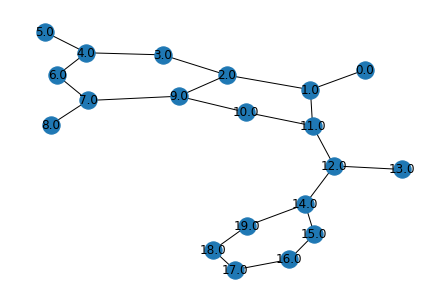

In [25]:
G = nx.Graph()
G.add_edges_from(edges_in_coo.T)
G.add_nodes_from(nodes)
nx.draw(G, with_labels=True)
plt.show()

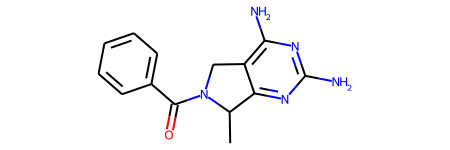

In [24]:
molecule

# Dataset
- https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html
- https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/data/dataset.html#Dataset


In [48]:
from torch_geometric.data import Dataset, download_url
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import os

In [39]:
os.listdir("./data/raw")

['HIV_test.csv', 'HIV_train_oversampled.csv', 'HIV_train.csv']

In [58]:
class MoleculeDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
    
    @property
    def raw_file_names(self):
        raw_files = ["HIV_train.csv"] 
        return raw_files

    @property
    def processed_file_names(self):
        return os.listdir(self.processed_dir)

    def download(self):
        pass

    def get_node_features(self, molecule_obj=None):
        """
        """
        node_features = []
        for atom in molecule_obj.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())
            node_features.append(node_feats)

        node_features = np.asarray(node_features)
        return torch.tensor(node_features, dtype=torch.float)

    def get_edge_idx_and_features(self, molecule_obj=None):
        """
            Get Edge index in COO format 
            and 
            Edge Feature from the molecule object.
        """
        edge_features, edge_index = [], []
        for bond in molecule_obj.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())

            i_atom_idx = bond.GetBeginAtomIdx() # n_i
            j_atom_idx = bond.GetEndAtomIdx() # n_j

            edge_features += [edge_feats, edge_feats]

            edge_index += [
                           [i_atom_idx, j_atom_idx], 
                           [j_atom_idx, i_atom_idx]
                        ]
        edge_index_np = np.asarray(edge_index, np.long).T.reshape(2, -1)
        edge_features_np = np.asarray(edge_features, np.float)

        return torch.tensor(edge_features_np), torch.tensor(edge_index_np)

    def get_graph_label(self, label=None):
        """"""
        label_np = np.asarray([label])
        return torch.tensor(label_np, dtype=torch.int64))        

    def process(self):
        raw_path = self.raw_paths[0]
        df = pd.read_csv(raw_path)
        smiles = df["smiles"].values
        labels = df["HIV_active"].values
        total_len = df.shape[0]
        idx = 0
        loop = tqdm(enumerate(zip(smiles, labels)), total=total_len)
        for idx, (smile, label) in loop:
            smile_mol = Chem.MolFromSmiles(smile)
            node_features = self.get_node_features(smile_mol)
            edge_features, adj_coo = self.get_edge_idx_and_features(smile_mol)
            molecule_label = self.get_graph_label(label)

            data = Data(x=node_features, 
                        edge_index=adj_coo, 
                        edge_attr=edge_features, 
                        y=molecule_label,
                        smiles=smile
                        )

            if self.pre_filter is not None and not self.pre_filter(data):
                continue

            if self.pre_transform is not None:
                data = self.pre_transform(data)

            torch.save(data, os.path.join(self.processed_dir, f'data_{idx}.pt'))
            idx += 1

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(os.path.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [59]:
mol_dataset = MoleculeDataset(root="./data")

Processing...
  0%|          | 0/37128 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

In [61]:
mol_dataset[0]

Data(x=[20, 9], edge_index=[2, 44], edge_attr=[44, 2], y=[1], smiles='CC1c2nc(N)nc(N)c2CN1C(=O)c1ccccc1')

In [63]:
len(os.listdir("./data/processed"))

37130

## Train and Test Split

In [67]:
train_size = int(len(mol_dataset) * 0.8)
train_set = mol_dataset[:train_size]
test_set = mol_dataset[train_size:]

# Dataloader

In [64]:
from torch_geometric.loader import DataLoader

In [69]:
BATCH_SIZE = 64 # no. of graphs in a batch
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [78]:
for a_batch in train_loader:
    print(a_batch)
    # print(y)
    break

DataBatch(x=[1540, 9], edge_index=[2, 3302], edge_attr=[3302, 2], y=[64], smiles=[64], batch=[1540], ptr=[65])


In [77]:
logger.info(train_size)
logger.info(f"{train_size/BATCH_SIZE}")
logger.info(len(train_loader))

2022-02-16 16:52:59.580 | INFO     | __main__:<module>:1 - 29704
2022-02-16 16:52:59.584 | INFO     | __main__:<module>:2 - 464.125
2022-02-16 16:52:59.586 | INFO     | __main__:<module>:3 - 465
